In [30]:
%run basic.ipynb

# General Utilities 

This will be included in all the files as generic utilities

In [39]:
%%writefile  gen/utils1.py
#!/usr/local/bin/python 
'''
Some utility Functions to be used in all the apps
#=*** NOTE *** DO NOT EDIT THIS FILE - THIS iS CREATED FROM: 01_utils.ipynb
'''
import re, sklearn, sys, os, datetime, getopt, glob, argparse, json, base64, pickle
import numpy as np
import pandas as pd
sys.path.append(".")
sys.path.append("gen")

#-----------------------------------------------------------------------------------
def inJupyter():
    try:    get_ipython; return True
    except: return False

def getconfig(cf = "config*"):
    confFiles = sorted(glob.glob(cf))
    if ( len(confFiles) <= 0):
        print(f"No Configuration files {cf} found!!!")
        exit(1)

    # Read and merge the configuration files
    ret = {}
    for cf in confFiles:
        print(f"#Getting Configuration from {cf}")
        with open(cf, "r") as f:
            cf = f.read()

        if (not cf.find('[START]') >=0 ):
            r1 = cf
        else:
            r1=re.findall("\[START](.*)\[END]", cf, flags=re.MULTILINE|re.DOTALL)
            if ( len(r1) <= 0):
                print(f"Ignoring: Configuration not found in {cf}! no worries")
                continue
            r1 = r1[0].replace("'", '"')    
        rj = eval(r1)
        ret.update(rj)
                
    return ret
    
#-----------------------------------------------------------------------------------
def getConfigList(conf, key=""):
    #print(f"Getting {key}")
    ll = conf.get(key, []);
    ret = []
    for l in ll:
        if type(l) == list:
            ret += l
        elif l.startswith("$"):
            ret += getConfigList(conf, l[1:])
        else:
            ret.append(l)

    return ret
#-----------------------------------------------------------------------------------
def getConfigObject(conf, key=""):
    ll = conf.get(key, "");
    if not ll:
        return;
    
    sst = ll[0]
    dec = base64.b64decode(sst)
    ret = pickle.loads(dec, fix_imports=True)

    return ret
#--------------------------------------------------------------------------------
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
#--------------------------------------------------------------------------------
class Map(dict):
    """
    Example:
    m = Map({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])
    """
    def __init__(self, *args, **kwargs):
        super(Map, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.items():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.iteritems():
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(Map, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(Map, self).__delitem__(key)
        del self.__dict__[key]
        
#--------------------------------------------------------------------------------
def runMethod(pyMethod, **kwargs):
    spl = pyMethod.split('.');

    assert len(spl) >= 2, "Hmmm ... May be not what is intended!! module name"

    modName = ".".join(spl[:-1])
    __import__(modName, fromlist="dummy")

    funName = spl[-1]
    ret = None
    for v in sys.modules:
        if (v.startswith(modName)):
            method= getattr(sys.modules[v], funName)
            print(v, type(v), funName, method, type(method), callable(method))
            ret = method(**kwargs)
    return ret

#runMethod("gen.utils1.is_number", **{"s":"123.78"})

Overwriting gen/utils1.py


# Get Stocks Data

In [119]:
%%writefile  gen/getstocksdata.py
#!/usr/local/bin/python 

import os, datetime, glob, sys
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append(".")
sys.path.append("gen")
import time, datetime

'''
The following code: it is just here to protect my API-KEY code not really useful
for the problem at hand. If your key is in your or update your API_KEY then you may safely ignore 
this code.
'''

def getkey(key='password'):
    API_KEY, lines, file =None, None, os.path.expanduser('~/.keys/keys.json')
    if os.path.exists(file):
        with open(file, 'r') as f:
            r = f.read()
        j = eval(r)
        return j['AV_API_KEY'], j['NEWSAPI_KEY']

    #alpha_vantage key
    avk = decrypt('baTEje52rx+kAsuAN9PdxMeC03p/HuRVTzskLiso1/c=', key)
    newsk = decrypt('505Db5sDvHvptBPzE8IhsewneuanOKV3gKpN+26lS3A=', key)
    return avk, newsk;
        
def encrypt(msg_text = b'message', secret_key='password'):
    if (type(msg_text) == str):
        msg_text = bytes(msg_text, encoding='utf-8').rjust(32)
    if (type(secret_key) == str):
        secret_key = bytes(secret_key, encoding='utf-8') .rjust(32)

    cipher = AES.new(secret_key,AES.MODE_ECB) 
    encoded = base64.b64encode(cipher.encrypt(msg_text))
    ret = encoded.decode("utf-8")
    print(ret)
    return ret

def decrypt(encoded, secret_key='password'):
    if (type(secret_key) == str):
        secret_key = bytes(secret_key, encoding='utf-8') .rjust(32)

    cipher = AES.new(secret_key,AES.MODE_ECB) 
    if (type(encoded) == str):
        encoded = bytes(encoded, encoding='utf-8')
    decoded = cipher.decrypt(base64.b64decode(encoded))
    ret =decoded.decode("utf-8").strip()
    print(ret)
    return ret

'''
This will read required symbols and saves them to data directory
'''
def save_data(symbol, API_KEY="", check=True):
    from alpha_vantage.timeseries import TimeSeries
    
    outf = f'daily_{symbol}.csv'
    if (check and os.path.exists(outf)):
        
        dt = datetime.datetime.fromtimestamp(os.path.getmtime(outf))
        dn = datetime.datetime.now()
        ts = (dn - dt)
        hr = (ts.days * 24 * 60 * 60 + ts.seconds)//60//60
        if (hr < 4): #if it was created less than 4 hours ago
            print(f"{outf:22} exists, ... recently crested < 4 at {dt} ")
            return;
    ts = TimeSeries(key=API_KEY, output_format='pandas')
    
    retry = 0
    data = None
    while retry <= 5:
        try:
            print(f"Getting data for {symbol}")
            data, meta_data = ts.get_daily(symbol, outputsize='full')
            break;
        except ValueError as ve:
            retry += 1
            print(f"Sleep for a Minute, {retry}/5 attempts");
            time.sleep(60)
            
    if data is None:
        print(f"Could not get data for {symbol}")
        return data
    
    data.insert(0, 'timestamp', value=data.index)

    data.columns = 'timestamp,open,high,low,close,volume'.split(',')
    data.to_csv(outf, index=False)
    return data

'''
Read all the files in data with daily_*, reads them and returns a list
'''
def read_data():
    a={}
    for f in glob.glob('daily_*'):
        symbol = os.path.basename(os.path.splitext(f)[0]).split("_")[1]
        print(f'Reading {f} Symbol: {symbol}')
        df = pd.read_csv(f)
        df.sort_values(by='timestamp', ascending=False, inplace=True)
        df.index=(range(0,len(df)))
        ncs = ['timestamp'] + [f'{symbol}_{c}' for c in df.columns[1:]]
        df.columns = ncs
        a[symbol] = df
        
    minrows = min([len(d) for d in a.values()])
    return a, minrows, df

'''
Combines all the dataframes into one

The problem for us to join multiple index funds from ASIA is that they have different holidays
Therefore we have gaps in the trading days. Therefore 
'''
def combine_data(a, outp="stockdata.csv"):
    # Different excahnges have various holidays, therefore values may be missing  
    # Get All Data Frames and their corresponding time stamps
    #
    ar=np.array([d['timestamp'].values for d in a.values()])
    at=np.concatenate(ar)
    at=set(at)
    af = pd.DataFrame()
    af['timestamp'] = list(at);

    for k,v in a.items():
        #print(f"Getting {k:32} \r", end='')
        af=pd.merge(af,v, how="left", left_on="timestamp".split(), right_on="timestamp".split())
    print()
    af.sort_values(by='timestamp', ascending=True, inplace=True)
    af.dropna(inplace=True)
    af = af.reset_index(drop=True)
    #af = af.fillna(method='ffill' ).fillna(method='bfill')
    af.to_csv(outp, index=False)
    return af

def addDummyCols(df):
    tf1=df
    if ( "MSFT_+ve" not in tf1.columns):
        tf1.insert(1, "MSFT_+ve", value=[f"S__{k}" for k in np.random.randint(0,3, size=len(tf1))] )
    if ( "MSFT_-ve" not in tf1.columns):
        #tf.insert(1, "MSFT_-ve", value=[f"S__{k}" for k in np.random.randint(0,1, size=len(nf))] )
        tf1.insert(1, "MSFT_-ve", value=[k for k in np.random.randint(0,2, size=len(tf1))] )
    tf1.to_csv("stockdata_ext.csv", index=False);
    return tf1


def getdata(symbs='MSFT GLD GOOGL SPX AAPL IBM' , dontforce=False):
    
    stockfile="data/stockdata.csv"
    if (dontforce and os.path.exists(stockfile)):
        print(f"{stockfile} exists")
        return
    
    API_KEY = None  # Put your API KEY if you need to test data download or just use the data
    API_KEY, NEWS_API_KEY = API_KEY or getkey()

    #print("API_KEY ", API_KEY)
    for f in symbs.split():
        save_data(f, API_KEY=API_KEY)

    ASIA='''TOKYO 6758.T HITACHI 6501.T HNGKNG 0168.HK SHANGAI 601288.SS SHNZEN'''
    s=ASIA.split()
    ASIA = {k[0]:k[1] for k in   zip(s[0::2], s[1::2])}

    for k, v in ASIA.items():
        print(f'getting data for {k} => symbol {v}')
        save_data(v, API_KEY)

def getCombined():
    #Get All data togehe
    a, maxrows, ldf  = read_data()
    nf= combine_data(a, "stockdata.csv")
    addDummyCols(nf)
    return nf
    
#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False
#-----------------------------------------------------------------------------------
if __name__ == '__main__':
    if (not inJupyter()):
        t1 = datetime.datetime.now()
        getdata()
        getCombined();
        t2 = datetime.datetime.now()
        print(f"All Done in {str(t2-t1)} ***")
    else:
        pass
        '''
        a, minrows, ldf  = read_data()
        stockfile="data/stockdata.csv"
        nf= combine_data(a, stockfile)
        addDummyCols(nf)
        '''

Overwriting gen/getstocksdata.py


# Data Configure  - dataconfig.py

In [ ]:
%%writefile  gen/dataconfig.py
#!/usr/local/bin/python 

import re, sys, os, datetime, getopt, glob, argparse, datetime, json, base64, pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
sys.path.append(".")
sys.path.append("gen")
import utils1

#~~~~ Find any sensor highly correlated with time and drop them.
def detectTimeCorrelated(df, val=0.94):
    timeCorSensors = []
    if ( not 'time' in df.columns): #assume first column is time column
        dcols = ['time'] + [c for c in df.columns[1:]]
        df.columns = dcols
    
    timeser = pd.Series(df[['time']].values.reshape(-1))
    if ( timeser.dtype != np.number ):
        timeser = pd.to_datetime(timeser).astype(int)
    
    
    DROP_INDEX = 0;
    for sensor in df.columns:
        if (sensor == 'time'):
            continue;
        #print(f"#Testing {sensor}...")
        sensorSeries = pd.Series(df[sensor].values.reshape(-1))
        for i in range(8):
            c1 = timeser[i:].corr(sensorSeries[i:])
            c2 = timeser[i:].corr(sensorSeries[:-i])
            if np.abs(c1) >= val or np.abs(c2) >= val:
                timeCorSensors.append(sensor)
                DROP_INDEX = max(DROP_INDEX, i) #lets drop first few rows
                break;
                
    if ( len(timeCorSensors) > 0):
        print(f"#Time Cor: #{len(timeCorSensors)}, #Shape before:{df.shape}")
        #df.drop(timeCorSensors, axis=1, inplace=True)
        #df = df[DROP_INDEX:]
        #print(f"#After dropping: {DROP_INDEX} =>{df.shape}")
        
    return timeCorSensors
#-----------------------------------------------------------------------------------
def precheck(df):
    cols = df.columns[df.dtypes.eq('object')]
    if (len(cols) > 0):
        print(f"WARNING: *** Non numeric columns => {cols}")
        return 0
    return 1
#-----------------------------------------------------------------------------------
'Covert to one_hot encoding with prefix for columns'
def makeOneHotCols(tf1, oheCols=[]):
    ret = []
    for c in oheCols:
        one_hot = pd.get_dummies(tf1[c])
        ret += [f'{c}___{k}' for k in one_hot.columns]

    return ret
#-----------------------------------------------------------------------------------
def detectCols(file, nUnique=4, tcoeff=0.92):
    tf1 = file
    if (type(tf1) == str):
        tf1 = pd.read_csv(tf1, comment="#")
    
    #Lets check if it has any non-numeric columns! Warning
    precheck(tf1)
    
    unique_vals  = tf1.nunique()
    constantCols = unique_vals[ unique_vals == 1].index                             # constant Columns
    onehotECols  = unique_vals[(unique_vals > 2 ) & (unique_vals<=nUnique)].index   # Categorical Columns
    categorCols  = unique_vals[(unique_vals >=2 ) & (unique_vals <= nUnique)].index # Categorical Columns
    binaryCols   = unique_vals[(unique_vals == 2)].index                      # Binary

    numericCols  = tf1.select_dtypes(include=np.number).columns           # numerics
    numericCols  = [c for c in numericCols if c not in categorCols]
    numericCols  = [c for c in numericCols if c not in constantCols]
    notNumerics  = tf1.select_dtypes(exclude=np.number).columns           # non - numerics
    notNumerics  = [c for c in notNumerics if c not in categorCols]       # non - numerics

    try:
        timeCorCols  = detectTimeCorrelated(tf1, tcoeff)
    except:
        timeCorCols = []
    
    onehotEC_ext = makeOneHotCols(tf1, onehotECols)
   
    ret1 =f'''[START]
{{
    "file"           : {[file] if (type(file) == str) else ["??"]},
    "nrowsXncols"    : {[len(tf1), len(tf1.columns )] }     , 
    "number_Unique"  : {nUnique}            , 
    "constantCols"   : {list(constantCols )},   # No Signals
    "#constantCols"  : {len(constantCols  )},   # No Signals
    "categorCols"    : {list(categorCols  )},   # Categorical Columns
    "#categorCols"   : {len(categorCols   )},   # Categorical Columns
    "onehotECols"    : {list(onehotECols  )},   # Cats > 2 and < Unique Values
    "onehotEC_ext"   : {list(onehotEC_ext )},   # Cats > 2 and < Unique Values
    "#onehotECols"   : {len(onehotECols   )},   # Cats > 2 and < Unique Values
    "binaryCols"     : {list(binaryCols   )},   # Binary
    "#binaryCols"    : {len(binaryCols    )},   # Binary
    "notNumerics"    : {list(notNumerics  )},
    "timeCorrelation": {tcoeff             },   # Time correlated
    "timeCorrCols"   : {list(timeCorCols  )},   # Time correlated Columns
    "#timeCorrCols"  : {len(timeCorCols   )},    # Time correlated Columns
    "excludePattern" : [] , #Exclude patterns
    "includePattern" : [] , #include patterns
    "dropColumns"    : [],
    "diff_suffix"    : {['__diff1']},
    "addDiffs"       : [],
    "train_pct"      : .9,
    "#numericCols"   : {len(numericCols   )},  
    "scaleInputs"    : {list(numericCols  )},  
    "scaleOutputs"   : {["$scaleInputs"]},  
    "inputs"         : {["$binaryCols", "$scaleInputs", "$onehotECols"]},
    "outputs"        : {["$scaleOutputs"]},
#-----Copy this generated file and add customization
    "tsParams"       : {{"length": 50, "batch_size": 1, "stride": 1, "sampling_rate": 1}},
    "networkModel"   : ["NN1 -> Example"],
    "lookahead"      : 1,
    "nsteps"         : 1,
    "scale"          : 1,
    "scaler"         : ["sklearn.preprocessing.MinMaxScaler()"],
    "scaler"         : ["sklearn.preprocessing.StandardScaler()"],
    "scalerXString"  : [],
    "scalerYString"  : []
}}
[END]
    '''

    return ret1, tf1;
#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False
    
def process():
    n  = len(sysargs.input_files)
    un = sysargs.unique
    tc = sysargs.tcoeff
    for i, file1 in enumerate(sysargs.input_files):
        print(f"#=>Processing {i+1}/{n} {file1} #unique: {un} tcoeff: {tc} - standby")
        outs, df = detectCols(file1, un, tc)
        
        break;
    print(outs)
    return outs
    
#-----------------------------------------------------------------------------------
sysargs=None
def addargs():
    sysargs = None
    p = argparse.ArgumentParser(f"{os.path.basename(sys.argv[0])}:")
    p.add_argument('-u', '--unique', type=int,   default=6,    help="# of unique values!")
    p.add_argument('-t', '--tcoeff', type=float, default=0.94, help="# Time Correlation value Sensors!")
    p.add_argument('args', nargs=argparse.REMAINDER)
    p.add_argument('input_files',action="store", type=str, nargs='+', help="input file(s)")

    #p.print_help() # always print -help
    try:
        sysargs=p.parse_args(sys.argv[1:])
        #print(f'using:\n{sysargs}')
    except argparse.ArgumentError as exc:
        #par.print_help()
        print(exc.message )
        
    return sysargs
#-----------------------------------------------------------------------------------
if __name__ == '__main__':
    if (not inJupyter()):
        t1 = datetime.datetime.now()
        sysargs = addargs()
        process()
        t2 = datetime.datetime.now()
        print(f"#All Done in {str(t2-t1)} ***")
    else:
        pass

In [9]:
f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/stockdata_ext.csv'
#r=detectCols(f)
#pp=r[0]

f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/daily_MSFT.csv'
pd.read_csv(f)

,timestamp,open,high,low,close,volume
0,2000-02-28,90.25,92.12,88.12,91.56,38065900.0
1,2000-02-29,91.75,91.75,88.87,89.37,29218700.0
...,...,...,...,...,...,...
5031,2020-02-27,163.32,167.03,157.98,158.18,93174906.0
5032,2020-02-28,152.41,163.71,152.00,162.01,96388312.0


# Data Prepare

In [ ]:
%%writefile  gen/dataprepare.py
#!/usr/local/bin/python 

import re, sklearn, sys, os, datetime, getopt, glob, argparse, datetime, json, base64, pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

sys.path.append(".")
sys.path.append("gen")
import utils1;

'''
Make sure data is sorted in asceding order of the time for LSTM to work and all these 
data prep tools to work.
'''


'Covert to one_hot encoding with prefix for columns'
def makeOneHot(tf1, oheCols=[]):
    ohe = pd.DataFrame();
    for c in oheCols:
        one_hot = pd.get_dummies(tf1[c])
        nc = [f'{c}___{k}' for k in one_hot.columns]
        one_hot.columns = nc
        ohe = pd.concat([ohe, one_hot], axis=1)

    return ohe

'''
Assuming the tf1 is sorted in ascending order of time
'''
def addDiff(tf1, col):
    #col = "MSFT_open"
    if (type(col) == str):
        col = [col]
    for c in col:
        if ( c not in tf1.columns):
            print(f"*WARNING* Column {c} Not FOUND")
            continue
        print(f"+++ Adding {c}")
        tf1[f'{c}___diff1'] = tf1[c] - tf1[c].shift(1)
    return tf1

#-----------------------------------------------------------------------------------
#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: inv_utils.ipynb
def inJupyter():
    try:    get_ipython; return True
    except: return False

#-----------------------------------------------------------------------------------
def formatConfig(out: dict):
    outj = f"[START]\n{{\n"
    for k,v in out.items():
        kk = f'"{k}"'
        vv = f"'{v}'" if type(v) == str else v
            
        outj += f'{kk:>20}: {vv},\n'
    outj += '"end": 0 \n}\n[END]\n'
    
    return outj

#-----------------------------------------------------------------------------------
def getFinalColumns(df, conf):
    inputCols = getConfigList(conf, "inputs")
    ouputCols = getConfigList(conf, "outputs")

    allcols = set(inputCols +ouputCols);
    
    assert allcols.issubset(set(df.columns)), "Hmmm ... columns missing"
    return sorted(list(allcols))
#-----------------------------------------------------------------------------------
'''
This will scale the numeric columns - if this changes - you need to use dataprep
'''
def scaleNumerics(df, conf={}):
    scaleInputCols = conf['scaleInputs']
    scaleOuputCols = conf['scaleOutputs']
    
    dfninps = df[ scaleInputCols ]
    dfnouts = df[ scaleOuputCols ]

    scale   = conf.get('scale', 0)
    dfninpsn, dfnoutsn, scalerX, scalerY = dfninps, dfnouts, None, None
    
    if (scale):
        scalerXStr = conf['scalerXString']
        scalerYStr = conf['scalerYString']
        trnPct     = conf.get('train_pct', 0.9);
        trnCnt     = int(len(df) * trnPct)

        conf["train_pct"   ] = trnPct
        conf["train_count" ] = trnCnt

        if (not scalerXStr):
            scaler  = conf.get('scaler', ["sklearn.preprocessing.MinMaxScaler()"]);
            scalerX = eval(scaler[0]) if type(scaler[0]) == str else scaler
            scalerX = scalerX.fit(dfninps[:trnCnt])
            scalerstr = base64.b64encode(pickle.dumps(scalerX, protocol=None, fix_imports=True))
            scalerstr = scalerstr.decode("utf-8")
            conf["scalerXString"] = [scalerstr]
            #print(f'==>+1 shape: {dfninps.shape} {scalerX.mean_}')
        else:
            scalerXStr = scalerXStr[0]
            decoded    = base64.b64decode(scalerXStr)
            scalerX    = pickle.loads(decoded,fix_imports=True)

        if (not scalerYStr):
            scaler  = conf.get('scaler', ["sklearn.preprocessing.MinMaxScaler()"]);
            scalerY = eval(scaler[0]) if type(scaler[0]) == str else scaler
            scalerY = scalerY.fit(dfnouts[:trnCnt])
            scalerstr = base64.b64encode(pickle.dumps(scalerY, protocol=None, fix_imports=True))
            scalerstr = scalerstr.decode("utf-8")
            conf["scalerYString"] = [scalerstr]
            #print(f'==>+2 shape: {dfninps.shape} {scalerY.mean_}')
        else:
            scalerYStr = scalerYStr[0]
            decoded    = base64.b64decode(scalerYStr)
            scalerY    = pickle.loads(decoded,fix_imports=True)

        di = scalerX.transform(dfninps)
        do = scalerY.transform(dfnoutsn)
        
        dfninpsn = pd.DataFrame(di, columns=scaleInputCols )
        dfnoutsn = pd.DataFrame(do, columns=scaleOuputCols )
        
        #print(f'==>++ shape: {dfninpsn.shape} {scalerX.mean_}')
        #print(f'==>++ shape: {dfnoutsn.shape} {scalerY.mean_}')

    return dfninpsn, dfnoutsn, scalerX, scalerY;
#-----------------------------------------------------------------------------------
def process(config, input_files, output=None):
    conf = utils1.getconfig(config)
    
    n  = len(input_files)
    adfInp = pd.DataFrame();
    for i, file1 in enumerate(input_files):
        print(f"=>Processing {i+1}/{n} {file1} - standby")
        df = pd.read_csv(file1, comment='#')
        
        drps = getConfigList(conf, "dropColumns")
        df.drop(drps, inplace=True, errors="ignore")
        
        # STEP 1: Add diffs
        cdiffs  = getConfigList(conf, 'addDiffs')
        addDiff(df, cdiffs)    #<< 1. Add tis
        df.dropna(inplace=True)
        df.reset_index(inplace=True, drop=True)

        # STEP 2: => One hot encode 
        ohe = None
        ohecols = getConfigList(conf, 'onehotECols')
        if len(ohecols) > 0:
            ohe=makeOneHot(df, conf['onehotECols'])  #< === ADD
            df=pd.concat([df,ohe], axis=1)
         
        # STEP 3: Add
        allCols = [df.columns[0]] + getFinalColumns(df,conf)
        dfunNormalized = df[allCols]
        #Numeric Columns
        dfiNorm, dfoNorm, sX, sY = scaleNumerics(dfunNormalized, conf)
        
        dfNormalized = dfunNormalized.copy()
        dfNormalized[dfiNorm.columns] = dfiNorm;
        dfNormalized[dfoNorm.columns] = dfoNorm;
        
        #FINALLY        
        if (output is not None):
            fi,ext = os.path.splitext(file1)
            nfu  = f'{os.path.basename(fi)}_Orig_{i}{ext}'
            print(f"writing unnormalized to: {nfu}")
            dfunNormalized.to_csv(nfu, index=False)
            
            
            nfn  = f'{os.path.basename(fi)}_Norm_{i}{ext}'
            print(f"writing normalized to. : {nfn}")
            dfNormalized.to_csv  (nfn, index=False)
            
            conf['normalizedFile']   = nfn
            conf['unnormalizedFile'] = nfu
            
        break;

    outj = formatConfig(conf)
    print(outj)
    
    return conf, dfunNormalized, dfNormalized
#-----------------------------------------------------------------------------------
sysargs=None
def addargs():
    sysargs = None
    p = argparse.ArgumentParser(f"{os.path.basename(sys.argv[0])}:")
    p.add_argument('-c', '--config', type=str, default="config.txt", help="Config Files")
    p.add_argument('-o', '--output', type=str, default=0, help="output file")
    p.add_argument('args', nargs=argparse.REMAINDER)
    p.add_argument('input_files',action="store", type=str, nargs='+', help="input file(s)")

    #p.print_help() # always print -help
    try:
        sysargs=p.parse_args(sys.argv[1:])
    except argparse.ArgumentError as exc:
        print(exc.message )
        
    return sysargs
    
#-----------------------------------------------------------------------------------
if __name__ == '__main__':
    if (not inJupyter()):
        t1 = datetime.datetime.now()
        sysargs = addargs()
        ret = process(sysargs.config, sysargs.input_files, sysargs.output)
        t2 = datetime.datetime.now()
        print(f"#All Done in {str(t2-t1)} ***")
    else:
        pass

In [ ]:
f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/stockdata_ext.csv'
f='/opt/SCHAS/NNBook/notebooks/NNetworks/LSTM/data/daily_MSFT.csv'
conf, dfUnNormalized, dfNormalized = process('config.*', [f], "out.csv")

# Custom Callback for Saving and Loading Models

In [13]:
%%writefile  gen/ccallbacks.py
#!/usr/local/bin/python 

import matplotlib.pyplot as plt
import re, sys, os, datetime, glob, json, base64, pickle, sklearn
import pandas as pd
import numpy as np

import keras
from keras.models import Model
from keras.models import load_model
from keras.callbacks import Callback
import IPython
from IPython.display import display

sys.path.append(".")
sys.path.append("gen")
import utils1;
import sklearn.metrics

class ModelCheckAndLoad(Callback):
    def __init__(self, filepath, monitor='val_loss', best=np.inf, 
                 stop_at=False, verbose=0, drawLoss=False):
        super(Callback, self).__init__()
        self.monitor  = monitor
        self.filepath = filepath
        self.verbose  = verbose
        self.best     = best or np.inf
        self.stop_at  = stop_at;
        self.history  = {}
        self.epochs   = []
        self.drawLoss = drawLoss
        self.epochNum = 0
        
    def save_ext(self):
        ef = self.filepath+"_ext"
        with open(ef, "wb") as f:
            myParams = {
                'best'     : self.best,
                'epochNum' : self.epochNum,
                'history'  : self.history
            }
            pickle.dump(myParams, f, protocol=pickle.HIGHEST_PROTOCOL)
                
    def load_ext(self):
        ret = None;
        if ( os.path.exists(self.filepath)):
            ret = load_model(self.filepath)
        
        ef = self.filepath+"_ext"
        if ( not os.path.exists(ef) or os.path.getsize(ef) <= 0):
            return ret
        
        with open(ef, "rb") as f:
            myParams      = pickle.load(f)
            self.best     = myParams.get('best'    , np.inf)
            self.epochNum = myParams.get('epochNum', 0);
            self.history  = myParams.get('history', {});
            
        print(f"Best Loaded {self.best}")
        return ret;

    def drawLosses(self):
        history, best = self.history, self.best
        #IPython.display.clear_output(wait=True)
        plt.clf()

        fig, ax1 = plt.subplots()
        i, colors, marks = 0, "rgbcmykw", "v.xo+"

        color = colors[i]
        ax1.set_xlabel('epochs')
        k, v = "loss", history['loss']
        ax1.set_ylabel(k, color=color)
        l1= ax1.plot(v, color=color, marker=marks[i], label=f"{k}")

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        i +=1
        k, v = "val_loss", history['val_loss']
        color = colors[i]
        ax2.set_ylabel(k, color=color)
        l2 = ax2.plot(v, color=color, marker=marks[i], label=f"{k}")

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        l3 = plt.plot(0, best, marker="o",  c="b", label=f"BEST: {best}")
        ax1.grid()

        lns  = l1 + l2 + l3;
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, loc=0)
        plt.show()
        
    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.epochNum += 1;
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.current = logs.get(self.monitor)
        if self.current is None:
            warnings.warn(f'Can save best model only with {self.monitor} available')
            return;
                    
        if (self.best > self.current):
            ou= f'{self.monitor}: {self.best} > {self.current}\n'
            print(f"Epoch: {epoch+1} Saving: {ou}");
            
            self.best = self.current
            self.model.save(self.filepath, overwrite=True)
            self.save_ext();
            self.model.stop_training = self.stop_at
        elif self.verbose > 0:
            ou= f'{self.monitor}: {self.best} <= {self.current}'
            print(f"{epoch+1} din't improve : {ou}\r", end="")
            
        if (self.drawLoss):
            drawLosses(self.history, self.best)

def predict(modelFile, valg, model=None):
    m1 = model or load_model(modelFile)
    #xxt = np.array([valg[i][0][0] for i in range(len(valg))])
    #yyt = np.array([valg[i][1][0] for i in range(len(valg))])
    yh=m1.predict(valg)
    return yh
            
def plot1(modelFile, valg, model=None, idx=0, n=-150, howmany=50):
    yh = predict(modelFile, valg, model)
    yy = np.array([valg[i][1][idx] for i in range(len(valg))])
                 
    plt.gcf().set_size_inches(22, 10, forward=True)
    plt.plot( yy[n:n+howmany], marker='o', label="original-")
    plt.plot( yh[n:n+howmany], marker='x', label="predicted")
    mse = sklearn.metrics.mean_squared_error(yy, yh)
    
    plt.title(f"{modelFile} : {model}: MSE: {mse} <==")
    plt.grid()
    plt.legend()
    plt.show()
    
    return yy, yh, mse


Overwriting gen/ccallbacks.py


# Build Model

## How to use 

```
mkdir ext
cd ext
./gen/dataconfig.py ../data/daily_MSFT.csv > config.1

```
** view config.1 <= script created a configuration of all the data found in time series file
** copy config.1 to config.2
** Edit config.2 and add customization as follows:

```
cp config.1 config.2

# 
[START]
{ 
          "addDiffs" : ['open'],
       "scaleInputs" : ['open', 'high', 'low', 'close', 'volume'],
      "scaleOutputs" : ['open', 'open___diff1'],
      "scaleOutputs" : ['open___diff1'],
            "inputs" : ['$binaryCols', '$scaleInputs', '$onehotEC_ext'],
            "inputs" : ['$scaleInputs'],
           "outputs" : ['$scaleOutputs'],
            "scaler" : ["sklearn.preprocessing.MinMaxScaler()"],

      "tsParams"     : {"length": 50, "batch_size": 1, "stride": 1, "sampling_rate": 1},
      "lookahead"    : 5,
      "nsteps"       : 1,
      "modelFile"    : ["simplemodel.h5"]
}
[END]
```

We will prepare the data combining all the configurations using dataprepare

```
../gen/dataprepare.py -c config\* ../data/daily_MSFT.csv  > myconfig 

[sscmm1zslvdr /opt/LMCO/git/notebooks/no-git/NNBook/notebooks/NNetworks/LSTM/exp] ls
config.1		daily_MSFT_Norm_0.csv	myconfig
config.2*		daily_MSFT_Orig_0.csv

```

This will create two files **daily_MSFT_Orig_0.csv** that is a normal data and normalized file **daily_MSFT_Norm_0.csv** ; the original file will add "difference

the CSV file will have both inputs and output
```
[sscmm1zslvdr /opt/LMCO/git/notebooks/no-git/NNBook/notebooks/NNetworks/LSTM/exp] head daily_MSFT_Orig_0.csv 

    timestamp   close   high    low      open   open___diff1   volume
0  2000-02-29   89.37   91.75   88.8700  91.75    1.50         29218700.0
1  2000-03-01   90.81   94.09   88.9400  89.62   -2.13         53444900.0
2  2000-03-02   93.37   95.37   91.1200  91.81    2.19         53466300.

...
```

In [19]:
%%writefile  gen/somemodels.py
#!/usr/local/bin/python 

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers

def SimpleModel1(history, nfeatures, nOut, **kwargs) :
    lstm_input = Input(shape=(history, nfeatures), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(nOut, name='dense_1')(x)
    output = Activation('linear', name='linear_output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    
    return model

def SimpleModel2(inps, inshape, units2=None, nsteps=1, opt="adam", loss="mse", bi=False, dropout=None):
    s= inshape
    print(locals())
    print(f"Creating LSTM: inuts= {inps} time-steps: {s[0]}, features: {s[1]} #out: {nsteps}")
    m = keras.models.Sequential()

    if (bi):
        m.add(keras.layers.Bidirectional(
            keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) ) )
    else:
        m.add(keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) )
    
    if(units2 is not None): #Lets just keep it simple for 2 layers only
        m.add(keras.layers.LSTM(units2, activation='relu'))
    if (dropout is not None):
        m.add( keras.layers.Dropout(dropout) )
    m.add(keras.layers.Dense(nsteps))
    m.compile(optimizer = opt, loss= loss)
    return m

def UberModel(lookBack, nFeatures, lstm_IPDim=256, lstm_OPDim=1, opt=None, loss="mse",  drop=0.3):
    opt        = opt or optimizers.Adam(lr=0.0005)
    k_rrizer   = None
    r_rrizer   = None

    input_layer  = Input(shape=(lookBack, nFeatures), dtype='float32', name='input')
    memory_layer = LSTM( lstm_IPDim, return_sequences=True, name="memory1")(input_layer)
    memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=False, name="memory2")(memory_layer)
    repeated     = RepeatVector(lookBack)(memory_layer)
    memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=True, name="first1out")(repeated)
    memory_layer = LSTM (lstm_IPDim,  return_sequences=True, name="first2out")(memory_layer)
    decoded_inputs = TimeDistributed(Dense(units=lstm_OPDim, activation='linear'))( memory_layer)

    #  Try spatial dropout?
    dropout_input = Dropout(drop)(input_layer)
    concat_layer  = concatenate([dropout_input, decoded_inputs])

    memory_layer = LSTM (units=lstm_IPDim, 
                             kernel_regularizer = k_rrizer, 
                             recurrent_regularizer = r_rrizer, 
                             return_sequences=False)(concat_layer)
    preds = Dense(units=lstm_OPDim, activation='linear')(memory_layer)

    model1 = Model(input_layer, preds)
    model1.compile(optimizer = opt, loss= loss)             

    return model1

Overwriting gen/somemodels.py


In [21]:
%%writefile  gen/lfit.py
#!/usr/local/bin/python 

import matplotlib.pyplot as plt
%matplotlib inline  

%load_ext autoreload
%autoreload 2

import re, sys, os, datetime, getopt, glob, argparse, json, base64, pickle
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
tf.random.set_seed(13)
pd.options.display.max_rows = 8

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
import numpy as np
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, Callback

sys.path.append(".")
sys.path.append("gen")
import utils1;
import ccallbacks

np.random.seed(4)

def getConf(cfile = "myconfig"):
    conf=utils1.getconfig(cfile)
    trnFile       = conf['normalizedFile']
    orgFile       = conf['unnormalizedFile']

    ddir = ""
    if not os.path.exists(trnFile):
        ddir = os.path.abspath(cfile)
        ddir = os.path.dirname(ddir) 
        trnFile       = f'{ddir}/{trnFile}'
        orgFile       = f'{ddir}/{orgFile}'

    normeddf     = pd.read_csv(trnFile)
    unnormdf     = pd.read_csv(orgFile)
    train_pct    = conf.get('train_pct', 0.9)
    traint_count = conf.get('train_count', int(len(normeddf) * train_pct) )
    inputs       = utils1.getConfigList(conf, 'inputs')
    ouputs       = utils1.getConfigList(conf, 'outputs')
    print(f'''
    TrnFile: {trnFile},
    I/P    : {inputs[0:4]} ...
    O/P    : {ouputs[0:4]} ...
    Shape  : {normeddf.shape}
    trnCnt : {traint_count}"
    ''')
    
    return conf, traint_count, unnormdf, normeddf, inputs, ouputs

def getGenerators(conf, normeddf, inputs, oututs):
    modelFile  = conf['modelFile'] or "models/simpleModel.h5"
    tsParams   = conf['tsParams']
    lookahead  = conf['lookahead']
    history    = tsParams['length']

    X, y = normeddf[inputs].values, normeddf[ouputs].values
    X=X[:(-lookahead+1) or None]
    y=y[lookahead-1:]

    Xtrn,ytrn = X[:train_count], y[:train_count], 
    Xtst,ytst = X[train_count:], y[train_count:], 

    tsParams1 = tsParams.copy()
    tsParams2 = tsParams.copy()
    tsParams2['batch_size'] =1

    trng1 = TimeseriesGenerator(Xtrn, ytrn, **tsParams1 )
    valg1 = TimeseriesGenerator(Xtst, ytst, **tsParams1 )
    valg2 = TimeseriesGenerator(X, y, **tsParams2 )

    #history, tsParams1, len(trng1), len(valg1), len(valg2), #trng1[0]
    #print(Xtrn.shape, "\n", Xtrn, "\n", ytrn.shape, "\n", ytrn, Xtst.shape)

    return modelFile, history, lookahead, trng1, valg1, valg2, X, y

def getModel(conf):
    modelFile = conf['modelFile']
    modelName = conf['modelName']
    loadModel = conf['loadModel']
    tsParams  = conf['tsParams']
    
    importName= modelName.split(".")[0]
    
    print(f'''
    import: {importName}
    using : {modelName}
    saved : {modelFile}
    reload: {loadModel}
    ''')
    
    exec(f"import {importName}")

    mcp= ccallbacks.ModelCheckAndLoad(modelFile, 'val_loss', best=np.inf, stop_at=False, verbose=1)
    if ( loadModel and os.path.exists(modelFile)):
        m1 = mcp.load_ext()
    if ( m1 is None):
        m1=eval(modelName)
    m1.summary()
        
    return m1, mcp


def fit(model, trng1, valg1, mcpoint,validation_steps=50, vv =0, ep = 1, spe =200 ):
    model.fit(trng1, verbose=vv, epochs=ep, validation_data=valg1,steps_per_epoch=spe, shuffle=True, 
                        validation_steps=validation_steps, callbacks=[mcpoint])


conf, train_count, unnormdf, normeddf, inputs, ouputs    = getConf("exp/myconfig")
modelFile, history, lookahead, trng1, valg1, valg2, X, y = getGenerators(conf, normeddf, inputs, ouputs)

#Lets keep the model as is
if "model" not in globals():
    model, mcpoint = getModel(conf)

fit(model, trng1, valg1, mcpoint, ep=3)
mcpoint.save_ext()

Overwriting gen/lfit.py


4982 6.407848474054845e-09


<Figure size 1152x360 with 0 Axes>

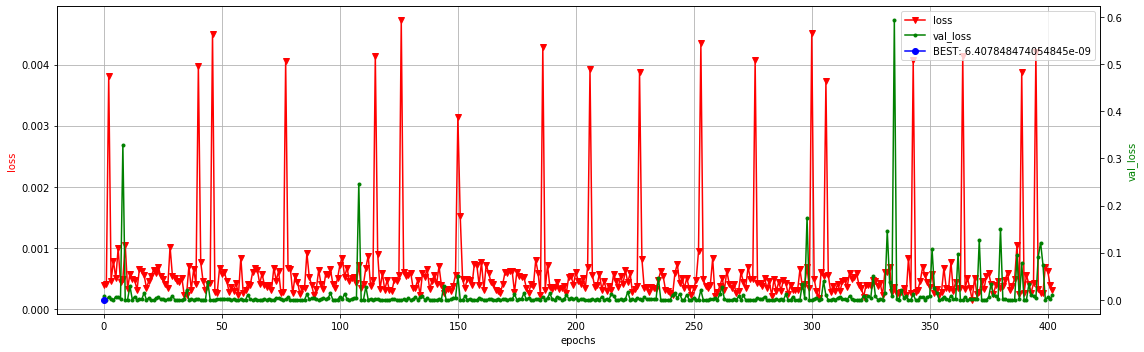

In [22]:
import sys
sys.path.append(".")
sys.path.append("gen")
import ccallbacks
print(len(valg2), mcpoint.best)
mcpoint.drawLosses()

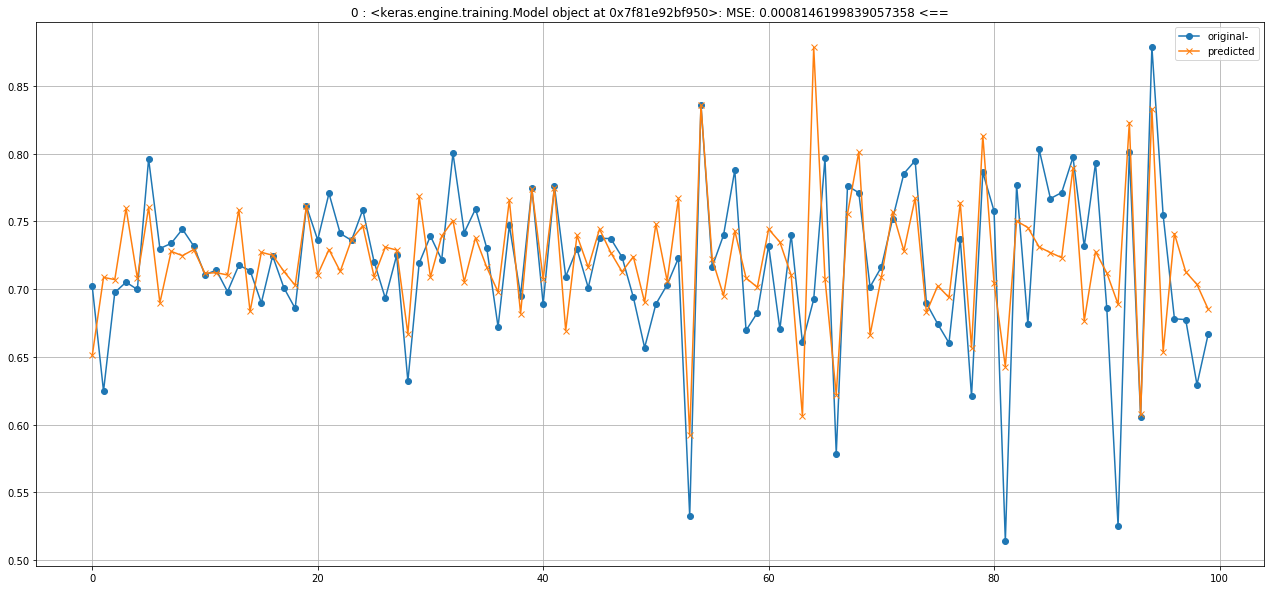

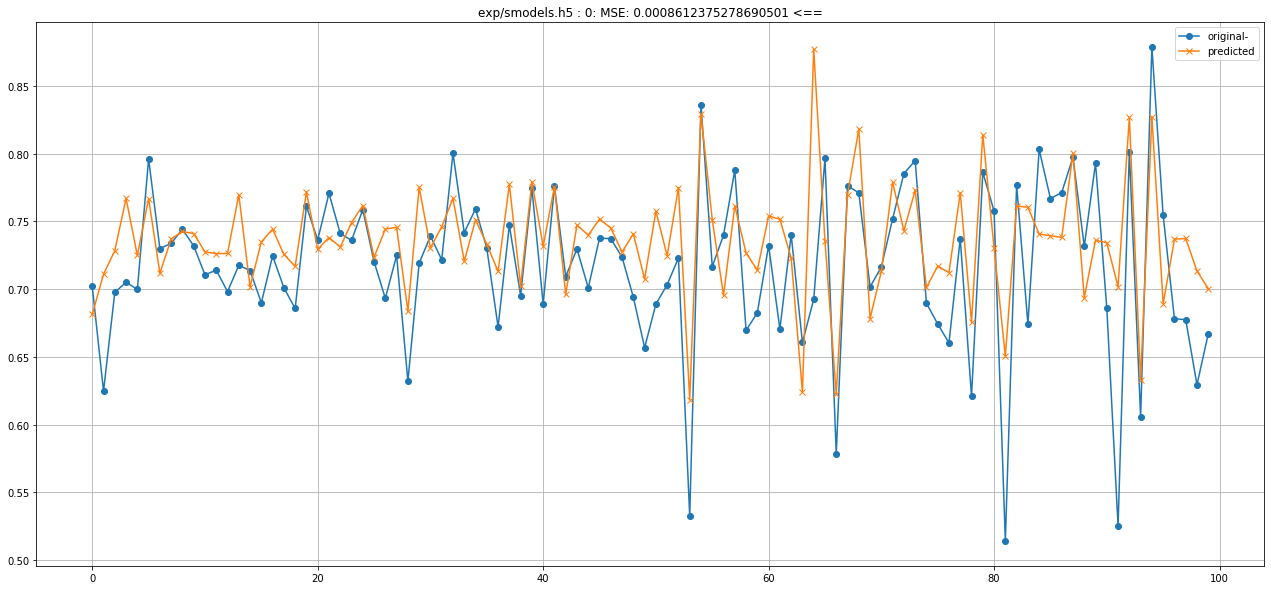

In [23]:
yy1, yh1,mse1 = ccallbacks.plot1(0, valg2, model, idx=0, n=-400, howmany=100);
plt.show()
yy, yh, mse = ccallbacks.plot1(mcpoint.filepath, valg2, 0, idx=0, n=-400, howmany=100);


# Move this to PY file

In [29]:
%%writefile  gen/util2.py
#!/usr/local/bin/python 

import matplotlib.pyplot as plt
%matplotlib inline  

%load_ext autoreload
%autoreload 2

import re, sys, os, datetime, getopt, glob, argparse, json, base64, pickle
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
tf.random.set_seed(13)
pd.options.display.max_rows = 8

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
import numpy as np
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, Callback

sys.path.append(".")
sys.path.append("gen")
import utils1;
import ccallbacks

np.random.seed(4)

def getInvertedPreds(conf, yh):
    scalerY = utils1.getConfigObject(conf, "scalerYString")
    sOuputs = utils1.getConfigList(conf, 'scaleOutputs')
    ouputs  = utils1.getConfigList(conf, 'outputs')
    
    yhdf    = pd.DataFrame(yh, columns=ouputs)    # Dataframe of Predictions
    ys      = yhdf[sOuputs].values                # Values to be scaledback
    yi      = scalerY.inverse_transform(ys)       # inverse transform the outputs
    yidf    = yhdf.copy()                         # Copy and set the values
    yidf[sOuputs] = yi
    return yhdf, yidf
    
def getOriginal(conf, unnormdf, index=0):
    inputs  = utils1.getConfigList(conf, 'inputs')
    ouputs  = utils1.getConfigList(conf, 'outputs')
    
    index   = 0
    startIX = index + tsParams['length']
    batchSZ = 1 # batch size
    stride  = tsParams.get('stride', 1)
    i = startIX + batchSZ * stride * index
    return unnormdf[i:], inputs, ouputs

def plotInverted(conf, yh, unnormdf, s =-400, howmany=100):
    e=s+howmany
    
    yhdf, yidf = getInvertedPreds(conf, yh)
    yorg,ips,ops = getOriginal(conf, unnormdf)

    x = pd.to_datetime(yorg[yorg.columns[0]][s:e])
    
    plt.plot(x, yorg[ops].values[s:e], marker='.', label="Original")
    plt.plot(x, yidf.values[s:e], marker='x', label="Predicted")
    plt.title("Plotting Inverted Values:")
    plt.grid()
    plt.legend()

'''
Reconstruct the original diffed columns
'''    
def reconstructOrig(conf, unnormdf, yh):
    yhdf, yidf = getInvertedPreds(conf, yh)
    yorg,ips,ops = getOriginal(conf, unnormdf)
    
    for o in ouputs:
        if(o.endswith("___diff1")):
            oc = o[:-8]
            print(f"Getting Original column for: '{oc}' ")
            if ( oc not in yorg.columns):
                print('Cannot compute the orginal column values from diffs for {oc}')
                continue;
                
            ## WOW <== this is heavy - undo the diffing in the opposite way
            yidf[oc] = yorg[oc].values + yidf[o].shift(-1)

    return yidf # y inverted dataframe with adjusted cols for diffs

yh = ccallbacks.predict(modelFile, valg2, model)
yidf = reconstructOrig(conf, unnormdf, yh)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'tsParams' is not defined

In [27]:
plotInverted(conf, yh, unnormdf, s=-400, howmany=100)

NameError: name 'tsParams' is not defined

In [ ]:
#Lets plot the original values and see how it looks
yidf

s=-400
e=s+100
col="open"
x = pd.to_datetime(unnormdf[unnormdf.columns[0]][s:e])
plt.plot(x, unnormdf[col][s:e], marker='.', label="Original")
plt.plot(x, yidf[col][s:e], marker='+', label="Predicted")


# EXTENDED Stuff for Future

In [ ]:
lookahead = 3
X, y = np.array(range(20)), np.array(range(20))
X=X[:(-lookahead+1) or None]
y=y[lookahead-1:]
print(f'{X}\n{y}')

print("---------------")
tsParams  = {"length": 5, "batch_size": 1, "stride": 1, "sampling_rate": 1}
train_count = len(X) * 6 //10

Xtrn,ytrn = X[:train_count], y[:train_count]
Xtst,ytst = X[train_count:], y[train_count:]
#Xtrn,ytrn = X, y 

print(Xtrn.shape, "\n", Xtrn, "\n", ytrn.shape, "\n", ytrn)
print(f'Test: {Xtst} {ytst}')
tsParams1 = tsParams.copy()
tsParams2 = tsParams.copy()
tsParams2['batch_size'] =1

trng1 = TimeseriesGenerator(Xtrn, ytrn, **tsParams1 )
valg1 = TimeseriesGenerator(Xtst, ytst, **tsParams1 )

for i in range(len(trng1)):
    print(f"{trng1[i][0]} : {trng1[i][1]}")
print("Testing ---")
for i in range(len(valg1)):
    print(f"{valg1[i][0]} : {valg1[i][1]}")

In [ ]:
tf1 = pd.DataFrame([i for i in range(0,5)])
tf1

In [ ]:
c=0
tf1[f'{c}___diff1'] = tf1[c] - tf1[c].shift(1)
tf1

In [ ]:
tf1[c].shift(1)